<a href="https://colab.research.google.com/github/Micmonta/liquid-democracy-models/blob/main/Democracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
DIRECT DEMOCRACY MODEL (Probalility Formula Model)
'''
from math import ceil
from decimal import Decimal
import operator as op
from functools import reduce

def comb(n, r):
    '''
    n: non-negative integer
    r: non-negative integer
    Returns: an integer value which represents the number of ways to choose k 
    items from n items without repetition and without order.
    '''
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def assign(limits, amount):
    '''
    limits: list of integers
    amount: integer
    Calling with `([3, 7, 5], 6)` means we want to assign 6 voters but only 3 
    fit in the first slot, 7 in the second, and 5 in the third.
    Will yield the next assignment with the first slot prioritized.
    e.g. [3, 3, 0] then [3, 2, 1] then [3, 1, 2] then [3, 0, 3] then [2, 4, 0] etc. up until [0, 1, 5]
    Yields None if an assignment is impossible (e.g. if you call with `([4, 5], 12)`
    '''
    limit = limits[0]
    current_slot = min(amount, limit)
    overflow = max(amount - limit, 0)
    if len(limits) == 1:
        # base case
        if overflow > 0:
            yield None
        else:
            yield [current_slot]
    else:
        # recursive case
        while current_slot >= 0:
            for future_answer in assign(limits[1:], overflow):
                if future_answer is not None:
                    yield [current_slot] + future_answer

            current_slot -= 1
            overflow += 1

def prob_vote(n_list, t_list, p_list):
    '''
    n_list: list of integers
    t_list: list of integers
    p_list: list of floats
    Returns: an Decimal value which represents the probality of all combinations 
    of voters in t_list voting with probaility in p_list and the remainder voting 
    with the complement. 
    '''
    if (len(t_list) < 1):
        return Decimal(0)
    result = Decimal(1)
    for i in range(len(t_list)):
        result *= Decimal(comb(n_list[i], t_list[i])) * Decimal(p_list[i] ** t_list[i]) * Decimal(1 - p_list[i])**(n_list[i] - t_list[i])
    return result

def P_DD_exact(n_list, p_list):
    '''
    n_list: list of integers
    p_list: list of floats
    Returns: an Decimal value which represents the probality that T wins the elections.
    n_list is the number of voters in each voter group and p_list is the compentency of voters in each group. 
    '''
    n = sum(n_list)
    rem = ceil(n / 2)
    prob = Decimal(0)
    for k in range(rem, n + 1):
        for t_list in assign(n_list, k):
            prob += prob_vote(n_list, t_list, p_list)
    return prob


In [ ]:
n_list = [3, 5, 2]
p_list = [3/4, 2/3, 4/5]
print(P_DD_exact(n_list, p_list))

0.9660288065843621726656339223


In [ ]:
'''
LIQUID DEMOCRACY MODEL (Iteration Model)
'''
from collections import defaultdict
from random import sample, random
from math import ceil

def make_star(g, f, p, m):
  assert(m < g + f)
  assert(g <= m)
  G = {}
  for i in range(g):
    G[i] = set()
  for i in range(g, g + f):
    G[i] = set(range(g))
    for j in range(m - g):
      G[i].add((i - g + j + 1) % f + g)
  for i in range(g + f, g + f + p):
   G[i] = set()
  return G

def make_comptency(g, f, p, p_g, p_f, p_p):
  comps = [0] * (g + f + p)
  for i in range(g):
    comps[i] = p_g
  for i in range(g, g + f):
   comps[i] = p_f
  for i in range(g + f, g + f + p):
    comps[i] = p_p
  return comps

def make_star_and_comptency(n_list, p_list, uniformity):
  return make_star(n_list[0], n_list[1], n_list[2], uniformity), make_comptency(n_list[0], n_list[1], n_list[2], p_list[0], p_list[1], p_list[2])

def maximum_delegation(G, P):
  VG = defaultdict(set)
  for i in range(len(G.keys())):
    max_comp = P[i]
    approved = set()
    for neighbour in G[i]:
      if P[neighbour] > max_comp:
        max_comp = P[neighbour]
    if max_comp == P[i]:
        approved.add(i)
    for neighbour in G[i]:
      if max_comp == P[neighbour]:
        approved.add(neighbour)
    if len(approved) >= 1:
      root = sample(approved, 1)[0]
      VG[root].add(i)
      while len(VG[i]) != 0 and root != i:
         VG[root].add(VG[i].pop())
    else:
      VG[i].add(i)
  return VG

def vote(VG, P):
  T_votes = 0
  total_weight = 0
  for i in VG:
    if random() < P[i]:
      T_votes += len(VG[i])
    total_weight += len(VG[i])
  return T_votes >= ceil(total_weight / 2)

def P_LD(G, P, iters):
  VG = maximum_delegation(G, P)
  T_wins = 0
  for i in range(iters):
    if vote(VG, P):
      T_wins += 1
  return round(T_wins / iters, 3)

'''
DIRECT DEMOCRACY MODEL (Iteration Model)
'''
def zero_delegation(G):
  VG = defaultdict(set)
  for i in range(len(G.keys())):
    VG[i].add(i)
  return VG

def P_DD(G, P, iters):
  VG = zero_delegation(G)
  T_wins = 0
  for i in range(iters):
    if vote(VG, P):
      T_wins += 1
  return round(T_wins / iters, 3)

'''
REPRESENTATIVE DEMOCRACY MODEL (Iteration Model)
'''
def full_delegation(G):
  VG = defaultdict(set)
  for i in range(len(G.keys())):
    if len(G[i]) == 0:
      VG[i].add(i)
    else: 
      break
  return VG

def P_RD(G, P, iters):
  VG = full_delegation(G)
  T_wins = 0
  for i in range(iters):
    if vote(VG, P):
      T_wins += 1
  return round(T_wins / iters, 3)


In [ ]:
G, P = make_star_and_comptency([3, 5, 2], [4/5, 2/3, 3/4], 4)
print(P_LD(G, P, 1000000))
print(P_DD(G, P, 1000000))
print(P_RD(G, P, 1000000))

In [ ]:
def vary_star(D, n_list, p_list):
  G, P = make_star_and_comptency(n_list, p_list, n_list[0] + 1)
  return D(G, P, 1000)

def starLD(n_list, p_list):
  return vary_star(P_LD, n_list, p_list)

def starDD(n_list, p_list):
  return vary_star(P_DD, n_list, p_list)

def starRD(n_list, p_list):
  return vary_star(P_RD, n_list, p_list)

def make_n_list(n):
  g = int(n * 3 / 10)
  p = int(n * 2 / 10)
  f = n - (g + p)
  return [g, f, p]

def make_n_list_f(n):
  g = 3
  p = 2
  f = n - (g + p)
  return [g, f, p]

In [ ]:
n_list = make_n_list_f(100)
G, P = make_star_and_comptency(n_list, [4/5, 2/3, 3/4], n_list[0] + 1)
maximum_delegation(G, P)

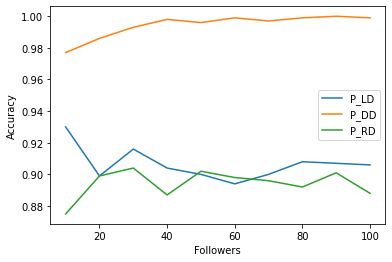

In [ ]:
'''
Case 1:
Voter Independence
No Voter Homogeneity
Voter Competence (gurus, followers, partisans)
Increasing followers (x-axis)
Fixed gurus, partisans
'''
import matplotlib.pyplot as plt
 
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = [starLD(make_n_list_f(n), [4/5, 2/3, 3/4]) for n in x]
y2 = [starDD(make_n_list_f(n), [4/5, 2/3, 3/4]) for n in x]
y3 = [starRD(make_n_list_f(n), [4/5, 2/3, 3/4]) for n in x]
plt.xlabel("Followers")
plt.ylabel("Accuracy")
plt.plot(x, y1, label="P_LD")
plt.plot(x, y2, label="P_DD")
plt.plot(x, y3, label="P_RD")
plt.plot()


plt.legend()
plt.show()

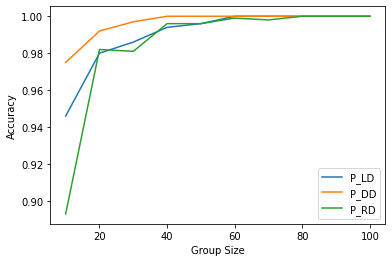

In [ ]:
'''
Case 2:
Voter Independence
No Voter Homogeneity
Voter Competence (gurus, followers, partisans)
Increasing group size (x-axis)
Ratio gurus:followers:partisans
'''
import matplotlib.pyplot as plt
 
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = [starLD(make_n_list(n), [4/5, 2/3, 3/4]) for n in x]
y2 = [starDD(make_n_list(n), [4/5, 2/3, 3/4]) for n in x]
y3 = [starRD(make_n_list(n), [4/5, 2/3, 3/4]) for n in x]
plt.xlabel("Group Size")
plt.ylabel("Accuracy")
plt.plot(x, y1, label="P_LD")
plt.plot(x, y2, label="P_DD")
plt.plot(x, y3, label="P_RD")
plt.plot()

plt.legend()
plt.show()

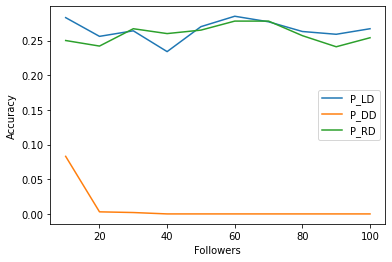

In [ ]:
'''
Case 3:
Voter Independence
No Voter Homogeneity
No Voter Competence (gurus, followers, partisans)
Increasing followers (x-axis)
Fixed gurus, partisans
'''
import matplotlib.pyplot as plt
 
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = [starLD(make_n_list_f(n), [1/3, 1/5, 1/4]) for n in x]
y2 = [starDD(make_n_list_f(n), [1/3, 1/5, 1/4]) for n in x]
y3 = [starRD(make_n_list_f(n), [1/3, 1/5, 1/4]) for n in x]
plt.xlabel("Followers")
plt.ylabel("Accuracy")
plt.plot(x, y1, label="P_LD")
plt.plot(x, y2, label="P_DD")
plt.plot(x, y3, label="P_RD")
plt.plot()


plt.legend()
plt.show()

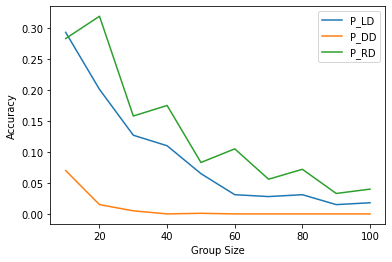

In [ ]:
'''
Case 4:
Voter Independence
No Voter Homogeneity
No Voter Competence (gurus, followers, partisans)
Increasing group size (x-axis)
Ratio gurus:followers:partisans
'''
import matplotlib.pyplot as plt
 
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = [starLD(make_n_list(n), [1/3, 1/5, 1/4]) for n in x]
y2 = [starDD(make_n_list(n), [1/3, 1/5, 1/4]) for n in x]
y3 = [starRD(make_n_list(n), [1/3, 1/5, 1/4]) for n in x]
plt.xlabel("Group Size")
plt.ylabel("Accuracy")
plt.plot(x, y1, label="P_LD")
plt.plot(x, y2, label="P_DD")
plt.plot(x, y3, label="P_RD")
plt.plot()

plt.legend()
plt.show()

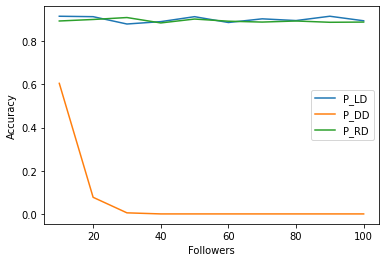

In [ ]:
'''
Case 5:
Voter Independence
No Voter Homogeneity
Voter Competence (gurus, partisans)
No Follower Competence
Increasing followers (x-axis)
Fixed gurus, partisans
'''
import matplotlib.pyplot as plt
 
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = [starLD(make_n_list_f(n), [4/5, 1/5, 3/4]) for n in x]
y2 = [starDD(make_n_list_f(n), [4/5, 1/5, 3/4]) for n in x]
y3 = [starRD(make_n_list_f(n), [4/5, 1/5, 3/4]) for n in x]
plt.xlabel("Followers")
plt.ylabel("Accuracy")
plt.plot(x, y1, label="P_LD")
plt.plot(x, y2, label="P_DD")
plt.plot(x, y3, label="P_RD")
plt.plot()


plt.legend()
plt.show()

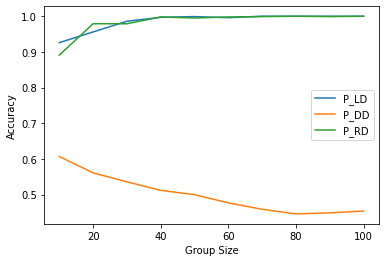

In [ ]:
'''
Case 6:
Voter Independence
No Voter Homogeneity
Voter Competence (gurus, partisans)
No Follower Competence
Increasing group size (x-axis)
Ratio gurus:followers:partisans
'''
import matplotlib.pyplot as plt
 
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = [starLD(make_n_list(n), [4/5, 1/5, 3/4]) for n in x]
y2 = [starDD(make_n_list(n), [4/5, 1/5, 3/4]) for n in x]
y3 = [starRD(make_n_list(n), [4/5, 1/5, 3/4]) for n in x]
plt.xlabel("Group Size")
plt.ylabel("Accuracy")
plt.plot(x, y1, label="P_LD")
plt.plot(x, y2, label="P_DD")
plt.plot(x, y3, label="P_RD")
plt.plot()

plt.legend()
plt.show()

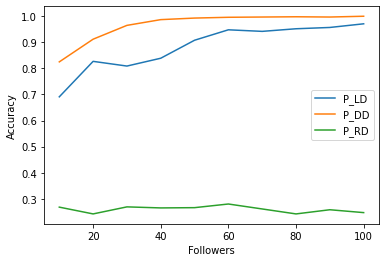

In [ ]:
'''
Case 7:
Voter Independence
No Voter Homogeneity
Voter Competence (followers, partisans)
No Guru Competence
Increasing followers (x-axis)
Fixed gurus, partisans
'''
import matplotlib.pyplot as plt
 
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = [starLD(make_n_list_f(n), [1/3, 2/3, 3/4]) for n in x]
y2 = [starDD(make_n_list_f(n), [1/3, 2/3, 3/4]) for n in x]
y3 = [starRD(make_n_list_f(n), [1/3, 2/3, 3/4]) for n in x]
plt.xlabel("Followers")
plt.ylabel("Accuracy")
plt.plot(x, y1, label="P_LD")
plt.plot(x, y2, label="P_DD")
plt.plot(x, y3, label="P_RD")
plt.plot()


plt.legend()
plt.show()

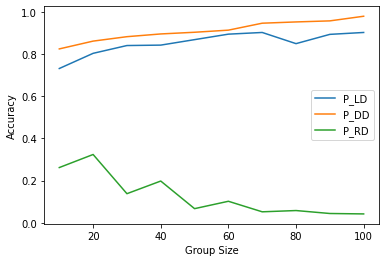

In [ ]:
'''
Case 8:
Voter Independence
No Voter Homogeneity
Voter Competence (followers, partisans)
No Guru Competence
Increasing group size (x-axis)
Ratio gurus:followers:partisans
'''
import matplotlib.pyplot as plt
 
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = [starLD(make_n_list(n), [1/3, 2/3, 3/4]) for n in x]
y2 = [starDD(make_n_list(n), [1/3, 2/3, 3/4]) for n in x]
y3 = [starRD(make_n_list(n), [1/3, 2/3, 3/4]) for n in x]
plt.xlabel("Group Size")
plt.ylabel("Accuracy")
plt.plot(x, y1, label="P_LD")
plt.plot(x, y2, label="P_DD")
plt.plot(x, y3, label="P_RD")
plt.plot()

plt.legend()
plt.show()

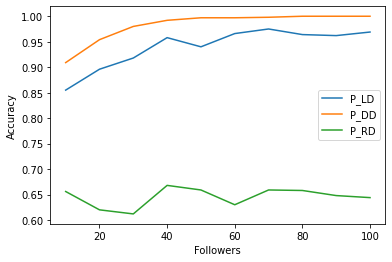

In [ ]:
'''
Case 10:
Voter Independence
No Voter Homogeneity
Voter Competence (gurus, followers, partisans)
Lesser Guru Competence
Increasing followers (x-axis)
Fixed gurus, partisans
'''
import matplotlib.pyplot as plt
 
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = [starLD(make_n_list_f(n), [3/5, 2/3, 3/4]) for n in x]
y2 = [starDD(make_n_list_f(n), [3/5, 2/3, 3/4]) for n in x]
y3 = [starRD(make_n_list_f(n), [3/5, 2/3, 3/4]) for n in x]
plt.xlabel("Followers")
plt.ylabel("Accuracy")
plt.plot(x, y1, label="P_LD")
plt.plot(x, y2, label="P_DD")
plt.plot(x, y3, label="P_RD")
plt.plot()


plt.legend()
plt.show()

The below  simulations may not fit with some previous assumptions. Such as having a voter types with non-homogenous comptencies. 

In [ ]:
'''
Case 9:
Voter Independence
No Voter Homogeneity
Voter Competence
Random Guru Competence Spread
Increasing followers (x-axis)
'''

In [ ]:
'''
Case 10:
Voter Independence
No Voter Homogeneity
Voter Competence 
Random Guru Competence Spread
Increasing followers (x-axis)
Ratio of gurus:followers
'''

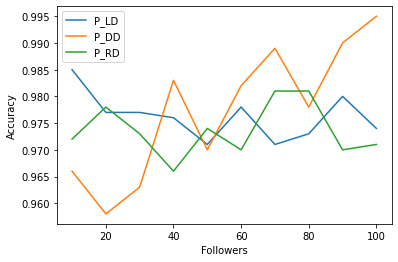

In [ ]:
'''
Case 11:
Voter Independence
No Voter Homogeneity
Voter Competence (gurus, followers, partisans)
Large guru - follower comptency difference
Increasing followers (x-axis)
Fixed gurus, partisans
'''
import matplotlib.pyplot as plt
 
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = [starLD(make_n_list_f(n), [.9, .6, 3/4]) for n in x]
y2 = [starDD(make_n_list_f(n), [.9, .6, 3/4]) for n in x]
y3 = [starRD(make_n_list_f(n), [.9, .6, 3/4]) for n in x]
plt.xlabel("Followers")
plt.ylabel("Accuracy")
plt.plot(x, y1, label="P_LD")
plt.plot(x, y2, label="P_DD")
plt.plot(x, y3, label="P_RD")
plt.plot()


plt.legend()
plt.show()

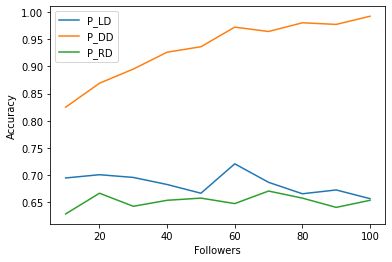

In [ ]:
'''
Case 11:
Voter Independence
No Voter Homogeneity
Voter Competence (gurus, followers, partisans)
Large guru - follower comptency difference
Increasing followers (x-axis)
Fixed gurus, partisans
'''
import matplotlib.pyplot as plt
 
x  = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y1 = [starLD(make_n_list_f(n), [.6, .6, .6]) for n in x]
y2 = [starDD(make_n_list_f(n), [.6, .6, .6]) for n in x]
y3 = [starRD(make_n_list_f(n), [.6, .6, .6]) for n in x]
plt.xlabel("Followers")
plt.ylabel("Accuracy")
plt.plot(x, y1, label="P_LD")
plt.plot(x, y2, label="P_DD")
plt.plot(x, y3, label="P_RD")
plt.plot()


plt.legend()
plt.show()